In [241]:
## 3 - Write Test Set to Disk and Use At the END for test(#nosnoop)

# Write to Disk
# df = pd.DataFrame(test_data)
# df.to_csv("test_data.csv")

In [3]:
## PREPROCESSING

## Cut Points and lengths

# format = [startpoint, endpoint, feature count]
contactsStartEnd = [0,1,1]
twitterStartEnd = [1,5,4]
textStartEnd = [5,78,73]
callStartEnd = [78,92,14]
instagramStartEnd = [92,110,18]
gpsStartEnd = [110,115,5]
audioStartEnd = [115,1698,1583]
labelStartEnd = [1698,1708,10]
allFeaturesStartEnd = [contactsStartEnd[0], audioStartEnd[1], 1698]


## Below function takes mtr, returns specified modality

# "con" contacts / "tw" twitter / "txt" text / "call" / 
# "ig" instagram / "gps" / au" audio / "label" / "all" big matrix
# "label10cutoff"


# X is big matrix, ftype is filetype, labeltype can be "continuous", "cutoffunbalanced", and "cutoffbalanced"

# returns list of two items, training data and training label

# eg:
# data, label = PPer(train_data, "au", "cutoffbalanced")
def PPer(X, ftype, labeltype):
    # cutoff can be varied
    PHQ9CUTOFF = 15
    if(ftype == "label"):
        nanfull = X[:,labelStartEnd[0]:labelStartEnd[1]]
        return nanfull
    if(ftype == "all"):
        startend = allFeaturesStartEnd
    if(ftype == "au"):
        startend = audioStartEnd
    if(ftype == "ig"):
        startend = instagramStartEnd
    if(ftype == "txt"):
        startend = textStartEnd
    if(ftype == "con"):
        startend = contactsStartEnd
    if(ftype == "tw"):
        startend = twitterStartEnd
    if(ftype == "call"):
        startend = callStartEnd
    if(ftype == "gps"):
        startend = gpsStartEnd
    nanfull = X[:,startend[0]:startend[1]] # carve out modality from matrix
    dataandlabel = np.hstack((nanfull, PPer(X, "label", "continuous"))) # glue data and label
    nanless = dataandlabel[~np.isnan(dataandlabel).any(axis=1)] # remove any entry with NaN
    if(labeltype == "continuous"): # normalize, return all phq answers + phq9 sum as label
        data = nanless[:,0:startend[2]]
        label = nanless[:,nanless.shape[1]-1:nanless.shape[1]]
        data = sklearn.preprocessing.scale(data)
        return [data,label]
    if(labeltype == "cutoffunbalanced"): # normalize, return binary label
        binarylabel = np.zeros((nanless.shape[0],1))
        for i in range(0,nanless.shape[0]):
            if(nanless[i][nanless.shape[1]-1] > PHQ9CUTOFF):
                binarylabel[i][0] = 1
            else:
                binarylabel[i][0] = 0
        data = nanless[:,0:startend[2]]
        data = sklearn.preprocessing.scale(data)
        label = binarylabel
        return [data,label]
    if(labeltype == "cutoffbalanced"):
        data, label = PPer(X, ftype, "cutoffunbalanced")
        nanless =  np.hstack((data, label))

        # count zeros and ones in labels
        onecounter = 0 # depressed
        zerocounter = 0 # non depressed
        for i in range(0,nanless.shape[0]):
            if(nanless[i][nanless.shape[1]-1] == 0):
                zerocounter += 1
            else:
                onecounter += 1

        binarybalanced = nanless[0:1,:]
        # less depressed ppl in set
        if(zerocounter > onecounter): 
            for i in range(0,nanless.shape[0]):
                # add every data point with 1 label 
                if(nanless[i][nanless.shape[1]-1] == 1):
                    binarybalanced = np.vstack((binarybalanced, nanless[i:i+1,:]))
            for i in range(0,nanless.shape[0]):
                if(onecounter == 0):
                    break
                # add same number of data points with 0 labels
                if(nanless[i][nanless.shape[1]-1] == 0):
                    binarybalanced = np.vstack((binarybalanced, nanless[i:i+1,:]))
                    onecounter -= 1
        # more depressed ppl in set 
        if(zerocounter < onecounter): 
            for i in range(0,nanless.shape[0]):
                # add every data point with 0 label 
                if(nanless[i][nanless.shape[1]-1] == 0):
                    binarybalanced = np.vstack((binarybalanced, nanless[i:i+1,:]))
            for i in range(0,nanless.shape[0]):
                if(zerocounter == 0):
                    break
                # add same number of data points with 0 labels
                if(nanless[i][nanless.shape[1]-1] == 1):
                    binarybalanced = np.vstack((binarybalanced, nanless[i:i+1,:]))
                    zerocounter -= 1

        np.random.shuffle(binarybalanced)
        data = binarybalanced[:,0:startend[2]]
        data = sklearn.preprocessing.scale(data)
        label = binarybalanced[:,startend[2]:binarybalanced.shape[1]]
        return [data,label]
        


In [440]:
# PREPROCESSING BUT WITHOUT TWITTER, INSTAGRAM AND GPS
# (a copy of above for the most part)

contactsStartEnd = [0,1,1]
twitterStartEnd = [1,5,4] #
textStartEnd = [5,78,73]
callStartEnd = [78,92,14]
instagramStartEnd = [92,110,18] #
gpsStartEnd = [110,115,5] #
audioStartEnd = [115,1698,1583]
labelStartEnd = [1698,1708,10]
allFeaturesStartEnd = [contactsStartEnd[0], audioStartEnd[1], 1698]



# this is to try dropping twitter, instagram and gps
def PPer_no_twiggps(X, ftype, labeltype):
    # cutoff can be varied
    PHQ9CUTOFF = 10
    if(ftype == "label"):
        nanfull = X[:,labelStartEnd[0]:labelStartEnd[1]]
        return nanfull
    if(ftype == "all"):
        startend = allFeaturesStartEnd
    startend = allFeaturesStartEnd
    startend[2] = 1671
        
        
        
    nanfull = X[:,startend[0]:startend[1]] # carve out modality from matrix
    
    
    one = X[:,contactsStartEnd[0]:contactsStartEnd[1]]
    two = X[:,textStartEnd[0]:callStartEnd[1]]
    three = X[:,audioStartEnd[0]:audioStartEnd[1]]
    
    nanfull = np.hstack((one, two, three))
    
    
    dataandlabel = np.hstack((nanfull, PPer(X, "label", "continuous"))) # glue data and label
    nanless = dataandlabel[~np.isnan(dataandlabel).any(axis=1)] # remove any entry with NaN
    if(labeltype == "continuous"): # normalize, return all phq answers + phq9 sum as label
        data = nanless[:,0:startend[2]]
        label = nanless[:,nanless.shape[1]-1:nanless.shape[1]]
        data = sklearn.preprocessing.scale(data)
        return [data,label]
    if(labeltype == "cutoffunbalanced"): # normalize, return binary label
        binarylabel = np.zeros((nanless.shape[0],1))
        for i in range(0,nanless.shape[0]):
            if(nanless[i][nanless.shape[1]-1] > PHQ9CUTOFF):
                binarylabel[i][0] = 1
            else:
                binarylabel[i][0] = 0
        data = nanless[:,0:startend[2]]
        data = sklearn.preprocessing.scale(data)
        label = binarylabel
        return [data,label]
    if(labeltype == "cutoffbalanced"):
        data, label = PPer(X, ftype, "cutoffunbalanced")
        nanless =  np.hstack((data, label))

        # count zeros and ones in labels
        onecounter = 0 # depressed
        zerocounter = 0 # non depressed
        for i in range(0,nanless.shape[0]):
            if(nanless[i][nanless.shape[1]-1] == 0):
                zerocounter += 1
            else:
                onecounter += 1

        binarybalanced = nanless[0:1,:]
        # less depressed ppl in set
        if(zerocounter > onecounter): 
            for i in range(0,nanless.shape[0]):
                # add every data point with 1 label 
                if(nanless[i][nanless.shape[1]-1] == 1):
                    binarybalanced = np.vstack((binarybalanced, nanless[i:i+1,:]))
            for i in range(0,nanless.shape[0]):
                if(onecounter == 0):
                    break
                # add same number of data points with 0 labels
                if(nanless[i][nanless.shape[1]-1] == 0):
                    binarybalanced = np.vstack((binarybalanced, nanless[i:i+1,:]))
                    onecounter -= 1
        if(zerocounter < onecounter): 
            for i in range(0,nanless.shape[0]):
                # add every data point with 0 label 
                if(nanless[i][nanless.shape[1]-1] == 0):
                    binarybalanced = np.vstack((binarybalanced, nanless[i:i+1,:]))
            for i in range(0,nanless.shape[0]):
                if(zerocounter == 0):
                    break
                # add same number of data points with 0 labels
                if(nanless[i][nanless.shape[1]-1] == 1):
                    binarybalanced = np.vstack((binarybalanced, nanless[i:i+1,:]))
                    zerocounter -= 1

        np.random.shuffle(binarybalanced)
        data = binarybalanced[:,0:startend[2]]
        data = sklearn.preprocessing.scale(data)
        label = binarybalanced[:,startend[2]:binarybalanced.shape[1]]
        return [data,label]

In [441]:
#### LOADING DATA

## 1 - Load Data

from sklearn import preprocessing
import pandas as pd
import numpy as np
import sklearn


mtr = pd.read_csv("mtr2.csv").values
mtr = np.delete(mtr, 0, axis = 1) # because dataframe adds a rogue column

np.random.shuffle(mtr)

## 2 - Split Data in Test and Train Set

numofppl_index = mtr.shape[0] 
cut_index = int(mtr.shape[0] * 0.70)

# Test (%15 percent of data)
test_data = mtr[cut_index:numofppl_index,:]

# Train (%85 percent of data)
train_data = mtr[0:cut_index,:]


In [425]:
ftypes = ["au","ig","txt","con","tw","call","gps"] # and "all"

for i in range(0,len(ftypes)):

    X,y = PPer(train_data, ftypes[i], "cutoffbalanced")
    print(X.shape)
    
X,y = PPer_no_twiggps(train_data, "all", "cutoffbalanced")
print(X.shape)

(185, 1583)
(9, 18)
(171, 73)
(177, 1)
(55, 4)
(167, 14)
(99, 5)
(3, 1671)


/home/vape/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [445]:
# CLASSIFICATION TRAINING EXPERIMENT (not final)

from sklearn.linear_model import RandomizedLasso
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix


ftypes = ["au","ig","txt","tw","call","gps"] # and "all"
# X = PPer(train_data_10_bal,"au")
# y = train_label_10_bal.reshape(244,)

clfs = []
rlassos = []
masks = []

for i in range(0,len(ftypes)):
    
    X,y = PPer(train_data, ftypes[i], "cutoffbalanced")
    y = y.reshape(y.shape[0],)

    rlasso = RandomizedLasso(alpha=0.001)
    rlasso.fit(X, y)
    X_lassod = rlasso.transform(X)
    
    masks.append(rlasso.get_support())
    rlassos.append(rlasso)
    
    c_range = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,1,2]
#     parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}
    parameters = {'kernel':('linear','poly'), 'C':c_range}

    svc = svm.SVC()

    grid = GridSearchCV(svc, parameters, cv=3, scoring='accuracy')
    grid.fit(X_lassod, y)

    clfs.append(grid.best_estimator_)

    from sklearn.metrics import classification_report


    grid.grid_scores_
    # grid.best_estimator_.get_params()
    print("----------HERE BE: " + ftypes[i].upper() + " --------------")
    print(grid.best_score_)
    predictions = grid.predict(X_lassod)
    print(classification_report(y, predictions))
    print(confusion_matrix(y, predictions))


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE: AU --------------
0.8264462809917356
             precision    recall  f1-score   support

        0.0       0.98      0.95      0.97        61
        1.0       0.95      0.98      0.97        60

avg / total       0.97      0.97      0.97       121

[[58  3]
 [ 1 59]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE: IG --------------
0.5555555555555556
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         4
        1.0       0.56      1.00      0.71         5

avg / total       0.31      0.56      0.40         9

[[0 4]
 [0 5]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vape/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE: TXT --------------
0.5412844036697247
             precision    recall  f1-score   support

        0.0       1.00      0.24      0.38        55
        1.0       0.56      1.00      0.72        54

avg / total       0.78      0.61      0.55       109

[[13 42]
 [ 0 54]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE: TW --------------
0.5135135135135135
             precision    recall  f1-score   support

        0.0       0.51      1.00      0.68        19
        1.0       0.00      0.00      0.00        18

avg / total       0.26      0.51      0.35        37

[[19  0]
 [18  0]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE: CALL --------------
0.5641025641025641
             precision    recall  f1-score   support

        0.0       0.68      0.29      0.40        59
        1.0       0.54      0.86      0.67        58

avg / total       0.61      0.57      0.53       117

[[17 42]
 [ 8 50]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE: GPS --------------
0.5070422535211268
             precision    recall  f1-score   support

        0.0       0.53      1.00      0.69        36
        1.0       1.00      0.09      0.16        35

avg / total       0.76      0.55      0.43        71

[[36  0]
 [32  3]]


In [446]:
clfs[0]

SVC(C=0.03, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1]:
## 1 - Load Data 

from sklearn import preprocessing
import pandas as pd
import numpy as np
import sklearn


mtr = pd.read_csv("mtr2.csv").values
mtr = np.delete(mtr, 0, axis = 1) # because dataframe adds a rogue column


## 2 - Split Data in Test and Train Set

numofppl_index = mtr.shape[0] 
cut_index = int(mtr.shape[0] * 0.85)

# Test (%15 percent of data)
test_data = mtr[cut_index:numofppl_index,:]

# Train (%85 percent of data)
train_data = mtr[0:cut_index,:]


In [15]:
# CLASSIFICATION FINAL TRAINING WITH BAGGING AND SVM

from sklearn.linear_model import RandomizedLasso
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree



ftypes = ["au","txt","tw","call","gps","ig","con"] # and "all"
# ftypes = ["txt"] # and "all"

# X = PPer(train_data_10_bal,"au")
# y = train_label_10_bal.reshape(244,)

clfs = []
rlassos = []

for i in range(0,len(ftypes)):
    
    X,y = PPer(train_data, ftypes[i], "cutoffbalanced")
    y = y.reshape(y.shape[0],)
        

    rlasso = RandomizedLasso(alpha=0.001)
    rlasso.fit(X, y)
    X_lassod = rlasso.transform(X)
    print("reducd num cols: " + str(X_lassod.shape[1]))
    rlassos.append(rlasso)
    
    
#     c_range = [0.01,0.1,1]
#     parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}
#     parameters = {'kernel':('linear','poly'), 'C':c_range}

    svc = svm.SVC(kernel='linear', C=0.01, class_weight={1: 1})
    
    if(ftypes[i] == "txt"):
        svc = svm.SVC(kernel='linear', C=0.01, class_weight={1: 1.12})
    
    if(ftypes[i] == "gps"):
        svc = svm.SVC(kernel='linear', C=0.01, class_weight={1: 1.2})

    if(ftypes[i] == "tw"):
        svc = svm.SVC(kernel='linear', C=0.01, class_weight={1: 1.3})
    
    if(ftypes[i] == "call"):
        svc = svm.SVC(kernel='linear', C=0.01, class_weight={1: 1.13})
    
    if(ftypes[i] == "au"):
        svc = svm.SVC(kernel='linear', C=0.01, class_weight={1: 4})
        
    if(ftypes[i] == "ig"):
        svc = svm.SVC(kernel='linear', C=0.1, class_weight={1: 1.3})
#     treee = tree.DecisionTreeClassifier()

    
    
    bagging = BaggingClassifier(svc)

    
    parameters = {'max_samples':(0.6,0.7), 'max_features':(0.9,0.99), 'n_estimators':(10,20,30)}
    if(ftypes[i] == "con"):
        parameters = {'max_samples':(0.6,0.7), 'n_estimators':(10,20,30)}
    

    
#     grid = GridSearchCV(bagging, parameters, cv=3, scoring='accuracy')
    grid = GridSearchCV(bagging, parameters, cv=3, scoring='accuracy')

    
    
    if(ftypes[i] != "con"):
        grid.fit(X_lassod, y)
    if(ftypes[i] == "con"):
        grid.fit(X, y)


    clfs.append(grid.best_estimator_)

    from sklearn.metrics import classification_report


    grid.grid_scores_
    # grid.best_estimator_.get_params()
    print("----------HERE BE TRAINING OF : " + ftypes[i].upper() + " --------------")
    print(grid.best_score_)
    predictions = grid.predict(X_lassod)
    print(classification_report(y, predictions))
    print(confusion_matrix(y, predictions))

    
    
    
    
#     ## test
#     Xtest,ytest = PPer(test_data, ftypes[i], "cutoffunbalanced")
#     ytest = ytest.reshape(ytest.shape[0],)

#     Xtest = rlasso.transform(Xtest)
    
    
#     print("reducd num cols: " + str(Xtest.shape[1]))
    
    
#     print("----------HERE BE TEST OF: " + ftypes[i].upper() + " --------------")
    
#     predictio = grid.predict(Xtest)
#     print(classification_report(ytest, predictio))
#     print(confusion_matrix(ytest, predictio))

    

/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


reducd num cols: 70
----------HERE BE TRAINING OF : AU --------------
0.8201438848920863
             precision    recall  f1-score   support

        0.0       1.00      0.86      0.92        70
        1.0       0.87      1.00      0.93        69

avg / total       0.94      0.93      0.93       139

[[60 10]
 [ 0 69]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


reducd num cols: 42
----------HERE BE TRAINING OF : TXT --------------
0.5813953488372093
             precision    recall  f1-score   support

        0.0       0.85      0.35      0.50        65
        1.0       0.59      0.94      0.72        64

avg / total       0.72      0.64      0.61       129

[[23 42]
 [ 4 60]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


reducd num cols: 4
----------HERE BE TRAINING OF : TW --------------
0.5102040816326531
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        25
        1.0       0.49      1.00      0.66        24

avg / total       0.24      0.49      0.32        49

[[ 0 25]
 [ 0 24]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


reducd num cols: 6
----------HERE BE TRAINING OF : CALL --------------
0.5407407407407407
             precision    recall  f1-score   support

        0.0       0.82      0.13      0.23        68
        1.0       0.52      0.97      0.68        67

avg / total       0.67      0.55      0.45       135

[[ 9 59]
 [ 2 65]]
reducd num cols: 5


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE TRAINING OF : GPS --------------
0.5061728395061729
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        40
        1.0       0.51      1.00      0.67        41

avg / total       0.26      0.51      0.34        81

[[ 0 40]
 [ 0 41]]
reducd num cols: 2


/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE TRAINING OF : IG --------------
0.5384615384615384
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         6
        1.0       0.54      1.00      0.70         7

avg / total       0.29      0.54      0.38        13

[[0 6]
 [0 7]]
reducd num cols: 1


/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE TRAINING OF : CON --------------
0.5103448275862069
             precision    recall  f1-score   support

        0.0       0.50      1.00      0.67        73
        1.0       0.00      0.00      0.00        72

avg / total       0.25      0.50      0.34       145

[[73  0]
 [72  0]]


/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# CLASSIFICATION TEST SET RESULTS

ftypes = ["au","txt","tw","call","gps","ig","con"] # and "all"
# ftypes = ["txt"] # and "all"

# X = PPer(train_data_10_bal,"au")
# y = train_label_10_bal.reshape(244,)


for i in range(0,len(ftypes)):
    
    Xtest,ytest = PPer(test_data, ftypes[i], "cutoffunbalanced")
    ytest = ytest.reshape(ytest.shape[0],)

    if(ftypes[i] != "con"):
        print(Xtest.shape)
        Xtest = rlassos[i].transform(Xtest)
        
    
        
    
    print("reducd num cols: " + str(Xtest.shape[1]))
    
    
    print("----------HERE BE TEST OF: " + ftypes[i].upper() + " --------------")
    
    predictio = clfs[i].predict(Xtest)
    print(classification_report(ytest, predictio))
    print(confusion_matrix(ytest, predictio))

(43, 1583)
reducd num cols: 70
----------HERE BE TEST OF: AU --------------
             precision    recall  f1-score   support

        0.0       0.50      0.21      0.30        28
        1.0       0.29      0.60      0.39        15

avg / total       0.43      0.35      0.33        43

[[ 6 22]
 [ 6  9]]
(41, 73)
reducd num cols: 42
----------HERE BE TEST OF: TXT --------------
             precision    recall  f1-score   support

        0.0       0.38      0.12      0.19        24
        1.0       0.36      0.71      0.48        17

avg / total       0.37      0.37      0.31        41

[[ 3 21]
 [ 5 12]]
(16, 4)
reducd num cols: 4
----------HERE BE TEST OF: TW --------------
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        12
        1.0       0.25      1.00      0.40         4

avg / total       0.06      0.25      0.10        16

[[ 0 12]
 [ 0  4]]
(41, 14)
reducd num cols: 6
----------HERE BE TEST OF: CALL --------------


/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [21]:
clfs[0]

BaggingClassifier(base_estimator=SVC(C=0.01, cache_size=200, class_weight={1: 4}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=0.99,
         max_samples=0.6, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [625]:
## SERVER INTEGRATION



#####################
#####################3
#####################
#####################3
#####################
#####################3
#####################


# This is where data is stored
# it is a dict where every key is the ID of a user
# The entry for each ID is another dict that looks like this
# {'text': [], 'log': [], "file": [], "calendar": [], "contact":[], "audio": []}
# I then add each piece of received data to the corresponding array
receivedData = {}


# Return a string version of whatever result we want to display
# INPUT - ID - the id (as a string) of the requesting device
def getClassification(ID):
    global receivedData

    userdata = receivedData[ID]

    scrapetime = userdata['scrapetime']
    
    textp = userdata['text']
    callp = userdata['log']
    conp = userdata['contact']
    audiop = userdata['audio']
    gpsp = userdata['gps']
#     instagramp = userdata['']
#     instagrammediap = userdata['']
    twitterp = ['tweets']
    
    
        ### INITIALIZATION
    
    # call frequency
    featureVectorCF = np.zeros((1,14))
    # follower count
    featureVectorFC = np.zeros((1,1))
    # following count
    featureVectorFC2 = np.zeros((1,1))
    # twitter like frequency
    featureVectorTWL = np.zeros((1,1))
    # twitter retweet frequency
    featureVectorTWRT = np.zeros((1,1))
    # num of contacts
    featureVectorNC = np.zeros((1,1))
    # instagram follows, followed by
    featureVectorIG1 = np.zeros((1,2))
    # instagram filter usage freq
    featureVectorIG2 = np.zeros((1,1))
    # instagram filter vec: Valencia, X-Pro II, Hefe, Amaro, Rise, Willow, Crema, Inkwell
    featureVectorIGFV = np.zeros((1,8))
    # instagram like freq, comment freq
    featureVectorIGLC = np.zeros((1,2))
    # instagram post freq
    featureVectorIG3 = np.zeros((1,1))
    # instagram avg Hue, Saturation, Value, and total faces
    featureVectorHSVF = np.zeros((1,4))
    # audio features from openSMILE
    featureVectorAUD = np.zeros((1,1583))
    # text frequency
    featureVectorTF = np.zeros((1,14))
    # 45 long POS (part of speech) vector
    POSFreqVec = np.zeros((1,45))
    # 14 long vector, 10 day sentiment average for past 14 days
    SentFreqVec = np.zeros((1,14))
    # gps feature 1
    gpsVector1 = np.zeros((1,1))
    # gps feature 2
    gpsVector2 = np.zeros((1,1))
    # gps feature 3
    gpsVector3 = np.zeros((1,1))
    # gps feature 4
    gpsVector4 = np.zeros((1,1))
    # gps feature 5
    gpsVector5 = np.zeros((1,1))
    

        ### FEATURIZATION
    
    f = Featurizer() 

    ## GPS
    gpsVector1[0] = f.numDiff(gpsp)
    gpsVector2[0] = f.maxDist(gpsp)
    gpsVector3[0] = f.totDist(gpsp)
    gpsVector4[0] = f.activeFreq(gpsp)
    gpsVector5[0] = f.distanceRan(gpsp)
    
    ## CALL
    featureVectorCF[i] = f.callFreqVec14(callp, scrapetime)
    
    ## SMS
    POSFreqVec[i] = f.POSTagger(textp)
    SentFreqVec[i] = f.SentAnalysis(textp, scrapetime)
    featureVectorTF[i] = f.textFreqVec14(textp, scrapetime)
    
    ## TWITTER
    featureVectorFC[i] = f.followerCount(twitterp)
    featureVectorFC2[i] = f.followingCount(twitterp)
    featureVectorTWL[i] = f.twitterLikeFreq(twitterp, scrapetime)
    featureVectorTWRT[i] = f.twitterRetweetFreq(twitterp, scrapetime)
            
    ## CONTACTS
    featureVectorNC[i] = f.numOfContacts(conp)
    
    ## CURRENTLY SERVER DOESNT SUPPORT INSTAGRAM!
#     ## INSTAGRAM
#     featureVectorIG1[i] = f.instagramThings(instagramp)
#     ## INSTAGRAM MEDIA
#     featureVectorIG2[i] = f.instagramFilterFreq(a6, self.list_of_times[i])
#     featureVectorIGFV[i] = f.instagramFilterVector(a6, self.list_of_times[i])
#     featureVectorIGLC[i] = f.instagramLikeComFreq(a6, self.list_of_times[i])
#     featureVectorIG3[i] = f.instagramPostFreq(a6, self.list_of_times[i])
#     featureVectorHSVF[i] = f.averageHSVF(a6, self.list_of_times[i])
            
    ## AUDIO
    featureVectorAUD[i] = f.voiceFeaturizer(audiop)
    

    
    
    ### VECTORIZATION
    
    GPSMtr = np.hstack((gpsVector1, 
                            gpsVector2, 
                            gpsVector3,
                            gpsVector4, 
                            gpsVector5))
    CallMtr = featureVectorCF        
    TextMtr = np.hstack((featureVectorTF, 
                                    SentFreqVec, 
                                    POSFreqVec))         
    TwitterMtr = np.hstack((featureVectorFC, 
                                     featureVectorFC2, 
                                     featureVectorTWL, 
                                     featureVectorTWRT))        
    ContactsMtr = featureVectorNC        
    IGMtr = np.hstack((featureVectorIG1, 
                                     featureVectorIG2, 
                                     featureVectorIGFV,
                                     featureVectorIGLC, 
                                     featureVectorIG3, 
                                     featureVectorHSVF))        
    AudioMtr = featureVectorAUD

    personvector = np.hstack((ContactsMtr, 
                            TwitterMtr, 
                            TextMtr, 
                            CallMtr, 
                            IGMtr,
                            GPSMtr,
                            AudioMtr))
    
    
    ## run this, or modalities thru classifiers
    personvector
    
    
    
    ftypes = ["au","ig","txt","con","tw","call", "gps"] 
    
    regressors = []
    rlassos = []

    for i in range(0,len(ftypes)):
        
        # load regression models from disk
        regressor = pickle.load(open("./persistentmodels/" +  str(ftypes[i]) + "_regressor.p", "rb" ))
        rlasso = pickle.load(open("./persistentmodels/" +  str(ftypes[i]) + "_rlassomask.p", "rb" ))
        
        # put em in a list
        regressors.append(regressor)
        rlassos.append(rlasso)

        
    # actual predicting
    AudioMtr = rlassos[0].transform(AudioMtr)
    audiopred = regressors[0].predict(AudioMtr)[0]
    
    TextMtr = rlassos[0].transform(TextMtr)
    txtpred = regressors[0].predict(TextMtr)[0]
    
    ContactsMtr = rlassos[0].transform(ContactsMtr)
    conpred = regressors[0].predict(ContactsMtr)[0]
    
    TwitterMtr = rlassos[0].transform(TwitterMtr)
    twpred = regressors[0].predict(TwitterMtr)[0]
    
    CallMtr = rlassos[0].transform(CallMtr)
    callpred = regressors[0].predict(CallMtr)[0]
    
    GPSMtr = rlassos[0].transform(GPSMtr)
    gpspred = regressors[0].predict(GPSMtr)[0]
    
    
    # we opted to equally weigh all regression results, 
    # instead of using the classifiers we trained through an ensemble
    
    # this is because our classifiers sucked on the testing set
    # but our regressors were great on the testing set
    # see MQP paper for more info.
    
    predictedPHQ9 = (audiopred+txtpred+conpred+twpred+callpred+gpspred)/6

    return predictedPHQ9

In [54]:
zes = []
# zes.append(5).append(6)
zes.append(5)
zes.append(5)
zes

[5, 5]

In [628]:
rec = {'text': [3], 'log': [], "file": [], "calendar": [], "contact":[]}
rec['log']

[]

In [39]:
# AUDIO ONLY CLASSIFICATION TRAIN


X,y = PPer(train_data, "au", "cutoffbalanced")
y = y.reshape(y.shape[0],)

rlasso = RandomizedLasso(alpha=0.001)
rlasso.fit(X, y)
X_lassod = rlasso.transform(X)



c_range = list(range(1, 15))
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

svc = svm.SVC()

grid = GridSearchCV(svc, parameters, cv=3, scoring='accuracy')
grid.fit(X_lassod, y)


predictions = grid.predict(X_lassod)
print(classification_report(y, predictions))
print(confusion_matrix(y, predictions))

/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


<bound method SelectorMixin.get_support of RandomizedLasso(alpha=0.001, eps=2.220446049250313e-16, fit_intercept=True,
        max_iter=500, memory=None, n_jobs=1, n_resampling=200,
        normalize=True, pre_dispatch='3*n_jobs', precompute='auto',
        random_state=None, sample_fraction=0.75, scaling=0.5,
        selection_threshold=0.25, verbose=False)>
             precision    recall  f1-score   support

        0.0       0.88      0.82      0.85       114
        1.0       0.84      0.89      0.86       115

avg / total       0.86      0.86      0.86       229

[[ 94  20]
 [ 13 102]]


In [43]:
print(rlasso.get_support())


[False False False ... False False False]


In [31]:
# REGRESSION FINAL TRAINING

ftypes = ["au","ig","txt","con","tw","call", "gps"] #and "all"
# X = PPer(train_data_10_bal,"au")
# y = train_label_10_bal.reshape(244,)
from sklearn.svm import SVR

clfsreg = []
rlassosreg = []

for i in range(0,len(ftypes)):

    X,y = PPer(train_data, ftypes[i], "continuous")
    y = y.reshape(y.shape[0],)

    # from sklearn.linear_model import RandomizedLasso

    rlasso = RandomizedLasso(alpha=0.001)
    rlasso.fit(X, y)
    X_lassod = rlasso.transform(X)

    rlassosreg.append(rlasso)

    c_range = list(range(1, 
                         15))
    parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

    svr = SVR()

    grid = GridSearchCV(svr, parameters, cv=4, scoring='neg_mean_squared_error')
    grid.fit(X_lassod, y)
    
    clfsreg.append(grid.best_estimator_)


    from sklearn.metrics import classification_report


    grid.grid_scores_
    # grid.best_estimator_.get_params()
    predictions = grid.predict(X_lassod)

    
    print("----------HERE BE : " + ftypes[i].upper() + " --------------")

    
    import math
    print(math.sqrt(int(grid.best_score_*-1)))
    # print(classification_report(y, predictions))
    # print(confusion_matrix(y, predictions))
    

/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE : AU --------------
5.744562646538029


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE : IG --------------
5.196152422706632


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE : TXT --------------
6.855654600401044


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE : CON --------------
7.0


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE : TW --------------
6.4031242374328485


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE : CALL --------------
6.928203230275509


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


----------HERE BE : GPS --------------
6.928203230275509


In [32]:
# REGRESSION TEST SET RESULTS

ftypes = ["au","ig","txt","con","tw","call", "gps"] #and "all"

for i in range(0,len(ftypes)):
    
    X,y = PPer(test_data, ftypes[i], "continuous")
    y = y.reshape(y.shape[0],)

    from sklearn.model_selection import cross_val_score


    X_lassod = rlassosreg[i].transform(X)


    scorz = cross_val_score(clfsreg[i], X_lassod, y, scoring='neg_mean_squared_error') 
    
    print("----------HERE BE TEST OF : " + ftypes[i].upper() + " --------------")

    print(math.sqrt(int(max(scorz)*-1)))


----------HERE BE TEST OF : AU --------------
5.656854249492381
----------HERE BE TEST OF : IG --------------
1.7320508075688772
----------HERE BE TEST OF : TXT --------------
5.477225575051661
----------HERE BE TEST OF : CON --------------
5.291502622129181
----------HERE BE TEST OF : TW --------------
4.242640687119285
----------HERE BE TEST OF : CALL --------------
5.385164807134504
----------HERE BE TEST OF : GPS --------------
6.708203932499369


In [43]:
clfsreg[6].predict(X_lassod[0:1,:])[0]

10.907271133031658

In [33]:
clfsreg[0]

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
# MODEL PERSISTENCE
import _pickle as pickle



ftypes = ["au","ig","txt","con","tw","call", "gps"] #and "all"

for i in range(0,len(ftypes)):

    pickle.dump(clfsreg[i], open( "./persistentmodels/" +  str(ftypes[i]) + "_regressor.p" , "wb" ))
    pickle.dump(rlassosreg[i], open("./persistentmodels/" + str(ftypes[i]) + "_rlassomask.p" , "wb" ))

    

In [27]:
grid.best_score_


-48.753051834396956

In [28]:
grid.best_estimator_.get_params()

{'C': 1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
# OLD PREPROCESSING (DEPRECATED)

# n gives nth phq answer
# 10 gives sum of all phqs
def Yer(y, n):
    return y[:,n-1:n]


contactsStartEnd = [0,1]
twitterStartEnd = [1,5]
textStartEnd = [5,78]
callStartEnd = [78,92]
instagramStartEnd = [92,110]
# gpsStartEnd = [110,113]

audioStartEnd = [110,1693]

allStartEnd = [contactsStartEnd[0], audioStartEnd[1]]


ftypes = ["au","ig","txt","con","tw","call","all"]

# ftype = "au" audio / "ig" instagram / "txt" text / "con" contacts / "tw" twitter / "call" call
# "all" = big matrix
def Xer(X, ftype):
    if(ftype == "au"):
        return X[:,audioStartEnd[0]:audioStartEnd[1]]
    if(ftype == "ig"):
        return X[:,instagramStartEnd[0]:instagramStartEnd[1]]
    if(ftype == "txt"):
        return X[:,textStartEnd[0]:textStartEnd[1]]
    if(ftype == "con"):
        return X[:,contactsStartEnd[0]:contactsStartEnd[1]]
    if(ftype == "tw"):
        return X[:,twitterStartEnd[0]:twitterStartEnd[1]]
    if(ftype == "call"):
        return X[:,callStartEnd[0]:callStartEnd[1]]
#     if(ftype == "gps"):
#         return X[:,gpsStartEnd[0]:gpsStartEnd[1]]
    if(ftype == "all"):
        return X[:,allStartEnd[0]:allStartEnd[1]]
    if(ftype == "audioless"):
        return X[:,allStartEnd[0]:gpsStartEnd[1]]
    if(ftype == "gpsless"):
        return np.hstack((X[:,allStartEnd[0]:instagramStartEnd[1]], X[:,audioStartEnd[0]:audioStartEnd[1]]))    
    
    


## PREPROCESSING

from sklearn import preprocessing
import pandas as pd
import sklearn

mtr = pd.read_csv("mtr1.csv").values
mtr = np.delete(mtr, 0, axis = 1) # because dataframe adds a rogue column
#mtr.shape

## PREPROCESSING
import pandas as pd
from sklearn.preprocessing import Imputer

# shuffle row-wise
np.random.shuffle(mtr)

data = mtr[:,allStartEnd[0]:allStartEnd[1]]

labels = mtr[:,1693:1704]



# replace missing values with mean of their corresponding features
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data = imp.fit_transform(data)

# If NaNs should be dropped instead:
# mtr = mtr[~np.isnan(mtr).any(axis=1)]

# normalize data (features now have gauss dist., 0 mean and unit variance)
data = sklearn.preprocessing.scale(data)


# THIS IS AN ALTERNATIVE TO 0 MEAN UNIT VARIANCE NORMALIZATION
# do this to scale features to range 0-1
# this must be done if a chi^2 is being performed

# min_max_scaler = preprocessing.MinMaxScaler()
# data = min_max_scaler.fit_transform(data)











In [569]:
## OLD PREPROCESSING (DEPRECATED)

# n gives nth phq answer
# 10 gives sum of all phqs
def Yer(y, n):
    return y[:,n-1:n]


contactsStartEnd = [0,1]
twitterStartEnd = [1,5]
textStartEnd = [5,78]
callStartEnd = [78,92]
instagramStartEnd = [92,110]
# gpsStartEnd = [110,113]

audioStartEnd = [110,1693]

allStartEnd = [contactsStartEnd[0], audioStartEnd[1]]


ftypes = ["au","ig","txt","con","tw","call","all"]

# ftype = "au" audio / "ig" instagram / "txt" text / "con" contacts / "tw" twitter / "call" call
# "all" = big matrix
def Xer(X, ftype):
    if(ftype == "au"):
        return X[:,audioStartEnd[0]:audioStartEnd[1]]
    if(ftype == "ig"):
        return X[:,instagramStartEnd[0]:instagramStartEnd[1]]
    if(ftype == "txt"):
        return X[:,textStartEnd[0]:textStartEnd[1]]
    if(ftype == "con"):
        return X[:,contactsStartEnd[0]:contactsStartEnd[1]]
    if(ftype == "tw"):
        return X[:,twitterStartEnd[0]:twitterStartEnd[1]]
    if(ftype == "call"):
        return X[:,callStartEnd[0]:callStartEnd[1]]
#     if(ftype == "gps"):
#         return X[:,gpsStartEnd[0]:gpsStartEnd[1]]
    if(ftype == "all"):
        return X[:,allStartEnd[0]:allStartEnd[1]]
    if(ftype == "audioless"):
        return X[:,allStartEnd[0]:gpsStartEnd[1]]
    if(ftype == "gpsless"):
        return np.hstack((X[:,allStartEnd[0]:instagramStartEnd[1]], X[:,audioStartEnd[0]:audioStartEnd[1]]))    
    
    


## PREPROCESSING

from sklearn import preprocessing
import pandas as pd
import sklearn

mtr = pd.read_csv("mtr1.csv").values
mtr = np.delete(mtr, 0, axis = 1) # because dataframe adds a rogue column
#mtr.shape

## PREPROCESSING
import pandas as pd
from sklearn.preprocessing import Imputer

# shuffle row-wise
np.random.shuffle(mtr)

data = mtr[:,allStartEnd[0]:allStartEnd[1]]
# data = np.hstack((X[:,allStartEnd[0]:instagramStartEnd[1]], X[:,audioStartEnd[0]:audioStartEnd[1]]))


labels = mtr[:,1693:1704]



# replace missing values with mean of their corresponding features
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data = imp.fit_transform(data)

# If NaNs should be dropped instead:
# mtr = mtr[~np.isnan(mtr).any(axis=1)]

# normalize data (features now have gauss dist., 0 mean and unit variance)
data = sklearn.preprocessing.scale(data)


# THIS IS AN ALTERNATIVE TO 0 MEAN UNIT VARIANCE NORMALIZATION
# do this to scale features to range 0-1
# this must be done if a chi^2 is being performed

# min_max_scaler = preprocessing.MinMaxScaler()
# data = min_max_scaler.fit_transform(data)










# DATA SPLIT (#nosnooping)

# TEST DATA (%15 percent of data)
numofppl_index = mtr.shape[0] - 1
cut_index = int(mtr.shape[0] * 0.85)

test_label = labels[cut_index:numofppl_index,:]
test_data = data[cut_index:numofppl_index,:]

# TRAINING AND VALIDATION DATA (%85 percent of data)

train_label = labels[0:cut_index,:]
train_data = data[0:cut_index,:]

In [567]:
train_label.shape

(255, 10)

In [409]:
## OLD PREPROCESSING (DEPRECATED)


# balancing for 15

onecounter = 0
onesdata = train_data[0:1,:]
oneslabel = train_label[0:1,1:2]
zerodata = train_data[1:2,:]
zerolabel = train_label[1:2,1:2]

for i in range(0,train_label.shape[0]):
    if(train_label[i:i+1,1:2] == 1):
        onecounter += 1
        onesdata = np.vstack((onesdata, train_data[i:i+1,:]))
        oneslabel = np.vstack((oneslabel, train_label[i:i+1,1:2]))

for i in range(0,train_label.shape[0]):
    if(onecounter == 0):
        break
    if(train_label[i:i+1,1:2] == 0):
        onecounter -= 1
        zerodata = np.vstack((zerodata, train_data[i:i+1,:]))
        zerolabel = np.vstack((zerolabel, train_label[i:i+1,1:2]))
        

train_data_15_bal = np.vstack((onesdata, zerodata))
train_label_15_bal = np.vstack((oneslabel, zerolabel))

np.random.shuffle(train_label_15_bal)
np.random.shuffle(train_data_15_bal)

In [410]:
## OLD PREPROCESSING (DEPRECATED)

# balancing for 20

onecounter = 0
onesdata = train_data[0:1,:]
oneslabel = train_label[0:1,2:3]
zerodata = train_data[1:2,:]
zerolabel = train_label[1:2,2:3]

for i in range(0,train_label.shape[0]):
    if(train_label[i:i+1,2:3] == 1):
        onecounter += 1
        onesdata = np.vstack((onesdata, train_data[i:i+1,:]))
        oneslabel = np.vstack((oneslabel, train_label[i:i+1,2:3]))

for i in range(0,train_label.shape[0]):
    if(onecounter == 0):
        break
    if(train_label[i:i+1,2:3] == 0):
        onecounter -= 1
        zerodata = np.vstack((zerodata, train_data[i:i+1,:]))
        zerolabel = np.vstack((zerolabel, train_label[i:i+1,2:3]))
        

train_data_15_bal = np.vstack((onesdata, zerodata))
train_label_15_bal = np.vstack((oneslabel, zerolabel))

np.random.shuffle(train_label_15_bal)
np.random.shuffle(train_data_15_bal)

In [568]:
## OLD PREPROCESSING (DEPRECATED)

# balancing for 10

onecounter = 0
onesdata = train_data[0:1,:]
oneslabel = train_label[0:1,0:1]
zerodata = train_data[1:2,:]
zerolabel = train_label[1:2,0:1]

for i in range(0,train_label.shape[0]):
    if(train_label[i:i+1,0:1] == 1):
        onecounter += 1
        onesdata = np.vstack((onesdata, train_data[i:i+1,:]))
        oneslabel = np.vstack((oneslabel, train_label[i:i+1,0:1]))

for i in range(0,train_label.shape[0]):
    if(onecounter == 0):
        break
    if(train_label[i:i+1,0:1] == 0):
        onecounter -= 1
        zerodata = np.vstack((zerodata, train_data[i:i+1,:]))
        zerolabel = np.vstack((zerolabel, train_label[i:i+1,0:1]))
        

train_data_10_bal = np.vstack((onesdata, zerodata))
train_label_10_bal = np.vstack((oneslabel, zerolabel))

tempmtr =  np.hstack((train_data_10_bal, train_label_10_bal))
np.random.shuffle(tempmtr)

train_data_10_bal = tempmtr[:,0:1693]
train_label_10_bal = tempmtr[:,1693:1694]

In [470]:
train_data_10_bal.shape

(244, 1693)

In [30]:
## OLD PREPROCESSING (DEPRECATED)


def cutoff(train_label):

    phqcutoffs = [10,15,20]

    for j in range(0,len(phqcutoffs)):
        for i in range(0,train_label[:,9:10].shape[0]):
            if(train_label[i][9] > phqcutoffs[j]):
                train_label[i][j] = 1
            else:
                train_label[i][j] = 0
               
    train_label_x = train_label
    
    return train_label_x               

def YerCutOff(y, cutoff):
    if (cutoff == 10):
        return y[:,0:1]
    if (cutoff == 15):
        return y[:,1:2]
    if (cutoff == 20):
        return y[:,2:3]
    
# train_label = cutoff(train_label)

In [367]:
## CLASSIFICATION TRAINING FOR CUTOFF 15 AND 20

from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.feature_selection import SelectFromModel

results = np.zeros((2,7))
paras = []

def HyperTunerSVM(trainX,trainy):
    
    ftypes = ["au","ig","txt","con","tw","call","all"] # and "all"
    cutoffs = [15,20]
    for i in range(0,len(ftypes)):
        for j in range(0,len(cutoffs)):
            
#             X = Xer(train_data, ftypes[i])
#             y = YerCutOff(train_label, cutoffs[j]).reshape(255,)
            X = Xer(train_data_15_bal, ftypes[i])
            y = train_label_15_bal.reshape(54,)
            
            c_range = list(range(1, 10))
            parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

            svc = svm.SVC()

            grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
            grid.fit(X, y)

            results[j][i] = grid.best_score_
            paras.append(grid.best_estimator_.get_params())


            
HyperTunerSVM(train_data, train_label)

In [368]:
df = pd.DataFrame(results, columns=["au","ig","txt","con","tw","call","all"])

df

,au,ig,txt,con,tw,call,all
0,0.444444,0.5,0.574074,0.481481,0.5,0.611111,0.518519
1,0.444444,0.5,0.574074,0.481481,0.5,0.611111,0.518519


In [471]:
train_data_15_bal.shape

(248, 1693)

In [481]:
X = Xer(train_data_10_bal,"txt")
X.shape

(244, 73)

In [494]:
## AUDIO CLASSIFICATION TRAINING SVM + RLASSO

ftypes = ["au","ig","txt","con","tw","call","all"] # and "all"
X = Xer(train_data_10_bal,"au")
y = train_label_10_bal.reshape(244,)

# au gives 85

# from sklearn.linear_model import RandomizedLasso


rlasso = RandomizedLasso(alpha=0.001)
rlasso.fit(X, y)
X_lassod = rlasso.transform(X)
X_lassod

c_range = list(range(1, 15))
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

svc = svm.SVC()

grid = GridSearchCV(svc, parameters, cv=3, scoring='accuracy')
grid.fit(X_lassod, y)


from sklearn.metrics import classification_report


grid.grid_scores_
# grid.best_estimator_.get_params()
grid.best_score_
predictions = grid.predict(X_lassod)
print(classification_report(y, predictions))
print(confusion_matrix(y, predictions))


/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


             precision    recall  f1-score   support

        0.0       0.75      0.91      0.82       122
        1.0       0.89      0.70      0.78       122

avg / total       0.82      0.80      0.80       244

[[111  11]
 [ 37  85]]


In [491]:
confusion_matrix(y, predictions)

array([[105,  17],
       [ 40,  82]])

In [398]:
grid.best_estimator_.get_params()
X_lassod.shape

(256, 91)

             precision    recall  f1-score   support

        0.0       0.74      0.85      0.79       128
        1.0       0.83      0.70      0.76       128

avg / total       0.78      0.78      0.78       256

[[109  19]
 [ 38  90]]


In [311]:
## AUDIO CLASSIFICATION TRAINING RANDOM FORREST + RLASSO

from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

results = np.zeros((2,7))
paras = []

def HyperTunerSVM(trainX,trainy):
    
    ftypes = ["au","ig","txt","con","tw","call","all"] # and "all"
    cutoffs = [15,20]
    for i in range(0,len(ftypes)):
        for j in range(0,len(cutoffs)):
            
            X = Xer(train_data, ftypes[i])
            y = YerCutOff(train_label, cutoffs[j]).reshape(255,)
            
            c_range = list(range(1, 10))
            parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

            
            min_sample_leaf = list(range(50,52))
            parameters = {'min_samples_leaf': min_sample_leaf}
            
            rfc = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=500, max_features=None, min_samples_leaf=50)

            grid = GridSearchCV(rfc, parameters, cv=2, scoring='accuracy')
            grid.fit(X, y)

            results[j][i] = grid.best_score_
            paras.append(grid.best_estimator_.get_params())


            
HyperTunerSVM(train_data, train_label)

In [312]:
df = pd.DataFrame(results, columns=["au","ig","txt","con","tw","call","all"])

df

,au,ig,txt,con,tw,call,all
0,0.705882,0.705882,0.705882,0.705882,0.705882,0.705882,0.705882
1,0.898039,0.898039,0.898039,0.898039,0.898039,0.898039,0.898039


In [313]:
paras[6]

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [327]:
clf1 = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=500, max_features=None, min_samples_leaf=50)
clf2 = svm.SVC(C=2, kernel="rbf", probability=True)

np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf1, clf2], weights=[1,1])

X = Xer(train_data, ftypes[i])
y = YerCutOff(train_label, 20).reshape(255,)

for clf, label in zip([clf1, clf2, eclf], ['randyforst', 'svm classifier', 'Ensemble']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.90 (+/- 0.00) [randyforst]
Accuracy: 0.90 (+/- 0.00) [svm classifier]
Accuracy: 0.90 (+/- 0.00) [Ensemble]


In [328]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

eclf.fit(X, y)

# grid.grid_scores_
# grid.best_estimator_.get_params()
# grid.best_score_
predictions = eclf.predict(X)
print(classification_report(y, predictions))
# print(confusion_matrix(y, predictions))

             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95       229
        1.0       0.00      0.00      0.00        26

avg / total       0.81      0.90      0.85       255



/home/vape/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [309]:
# 15 CUTOFF WITH CUSTOM ENSEMBLE EXPERIMENTAL 

clf1 = svm.SVC(C=1, kernel="rbf" , probability=True) #au
clf2 = svm.SVC(C=1, kernel="rbf" , probability=True) #ig
clf3 = svm.SVC(C=1, kernel="sigmoid" , probability=True) #txt
clf4 = svm.SVC(C=2, kernel="rbf" , probability=True) # con
clf5 = svm.SVC(C=1, kernel="rbf" , probability=True) # tw
clf6 = svm.SVC(C=1, kernel="rbf", probability=True) # call


eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3, clf4, clf5, clf6], weights=[1,1,1,1,1,1])

scores = []

ftypes = ["au","ig","txt","con","tw","call","all"]
for i in range(0,len(ftypes)):
    X = Xer(train_data, ftypes[i])
    y = YerCutOff(train_label, 15).reshape(255,)

    scores.append(cross_validation.cross_val_score(eclf, X, y, cv=2, scoring='accuracy'))


# for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):

#     scores = cross_validation.cross_val_score(clf, X, y, cv=2, scoring='accuracy')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [317]:
## CUSTOM ENSEMBLE CLASSIFIER SKELETON


from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):

        for clf in self.clfs:
            clf.fit(X, y)

    def predict(self, X):

        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)

        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])

        return maj

    def predict_proba(self, X):

        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg

In [ ]:
paras

In [281]:
############################ RANDOM FOREST FEATURE SELECTION #############################

from sklearn.ensemble import RandomForestRegressor

X = Xer(train_data, "all")
y = YerCutOff(train_label, 15).reshape(train_label.shape[0],)

# rdc = RandomForestRegressor(max_depth=2, random_state=0)#,max_features=None)
rdc = RandomForestRegressor(random_state=0, max_features=None)

# clf.fit(X, y)

n_estimators = list(range(500,501))
max_features = ["auto","sqrt","log2",0.2,0.4,0.6,0.8,None]
min_sample_leaf = list(range(50,52))
# parameters = {'min_samples_leaf': min_sample_leaf}
max_depth = list(range(50,52))
# parameters = {'min_samples_leaf': min_sample_leaf, 'n_estimators':n_estimators}
parameters = {'min_samples_leaf': min_sample_leaf, 'n_estimators':n_estimators}


grid = GridSearchCV(rdc, parameters, cv=2, scoring='neg_mean_squared_error')
grid.fit(X, y)


GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [50, 51], 'n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

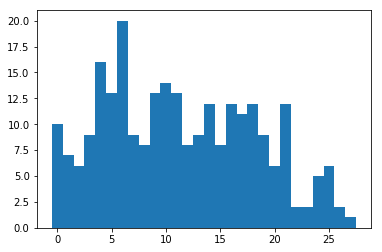

In [624]:
## GRAPHING PHQ 9 DISTRIBUTION

lizz = train_label[:,9:10].tolist()
lizzn = []
for i in range(0,len(lizz)):
    lizzn.append(lizz[i][0])
    
from collections import Counter

Counter(lizzn)


from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


labels, values = zip(*Counter(lizzn).items())

indexes = np.arange(len(labels))
# indexes = indexes*4
width = 1

plt.bar(indexes, values, width)
# plt.xticks(indexes + width * 0.5, labels)
# plt.tight_layout()
# plt.figure(figsize=(30,50))
# x = plt.axes([0,0,1,1])
plt.show()

In [605]:
indexes

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108])

In [142]:
## RLASSO SCORE EXPERIMENT

X = Xer(train_data, "all")
y = YerCutOff(train_label, 20).reshape(train_label.shape[0],)

from sklearn.linear_model import RandomizedLasso

rlasso = RandomizedLasso()
rlasso.fit_transform(X, y)

/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/home/vape/.local/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.156e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/vape/.local/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=1.078e-03, with an active set of 45 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)

array([], shape=(255, 0), dtype=float64)

In [162]:
rlasso.scores_[0:500]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.075, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,

In [166]:
X.shape

(255, 1693)

In [168]:
Xla = np.zeros((255, 1))

for i in range(0,len(rlasso.scores_)):
    if(rlasso.scores_[i] != 0):
        Xla = np.hstack((Xla, X[:,i:i+1]))

In [156]:
Xla = np.delete(Xla, 0, 1)

In [169]:
Xla.shape

(255, 66)

In [177]:
############################ SVC #############################
from sklearn.svm import SVC

svc = SVC(class_weight='balanced')

X = Xer(train_data, "all")
y = YerCutOff(train_label, 20).reshape(train_label.shape[0],)

# parameters = {}

# grid = GridSearchCV(regr, parameters, cv=2, scoring='explained_variance')
# grid.fit(X, y)

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
X = sel.fit_transform(X)

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':list([0.001,0.01,0.1,1,2,3,4,5,6,7,8,10])}


grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(Xla, y)

grid.best_score_

0.8235294117647058

In [178]:
grid.grid_scores_
# grid.best_score_

[mean: 0.76863, std: 0.01870, params: {'C': 0.001, 'kernel': 'linear'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.001, 'kernel': 'rbf'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.001, 'kernel': 'poly'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.001, 'kernel': 'sigmoid'},
 mean: 0.75294, std: 0.01864, params: {'C': 0.01, 'kernel': 'linear'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.01, 'kernel': 'rbf'},
 mean: 0.82353, std: 0.07382, params: {'C': 0.01, 'kernel': 'poly'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.01, 'kernel': 'sigmoid'},
 mean: 0.72157, std: 0.01286, params: {'C': 0.1, 'kernel': 'linear'},
 mean: 0.75686, std: 0.03042, params: {'C': 0.1, 'kernel': 'rbf'},
 mean: 0.77255, std: 0.01479, params: {'C': 0.1, 'kernel': 'poly'},
 mean: 0.76863, std: 0.01870, params: {'C': 0.1, 'kernel': 'sigmoid'},
 mean: 0.72941, std: 0.00286, params: {'C': 1, 'kernel': 'linear'},
 mean: 0.75686, std: 0.01473, params: {'C': 1, 'kernel': 'rbf'},
 mean: 0.76863, std: 0.0187

In [174]:
svc = SVC(class_weight='balanced', C=0.1, kernel='rbf')
parameters = {}

grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(Xla, y)


GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [88]:
grid.grid_scores_


[mean: 0.84706, std: 0.05158, params: {}]

In [179]:
from sklearn.metrics import classification_report

predictions = grid.predict(Xla)
print(classification_report(y, predictions))

             precision    recall  f1-score   support

        0.0       0.92      0.82      0.87       228
        1.0       0.20      0.37      0.26        27

avg / total       0.84      0.78      0.80       255



In [114]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(1.05))
Xsel = sel.fit_transform(X)
Xsel.shape

(255, 305)

In [117]:
svc = SVC(class_weight='balanced', C=0.1, kernel='rbf')
parameters = {}

grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(Xsel, y)
grid.grid_scores_

[mean: 0.84706, std: 0.05158, params: {}]

In [119]:
from sklearn.metrics import classification_report

predictions = grid.predict(Xsel)
print(classification_report(y, predictions))

             precision    recall  f1-score   support

        0.0       0.92      0.81      0.86       230
        1.0       0.17      0.36      0.23        25

avg / total       0.85      0.77      0.80       255



In [40]:
# CHI^2 EXPERIMENT

# X_new = SelectKBest(chi2, k=100).fit_transform(X, y)
# X_new.shape

parameters = {}

grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(X, y)

grid.best_score_

0.7058823529411765

In [202]:
Xla.shape

(255, 66)

In [197]:
############################ SVR #############################
from sklearn.grid_search import GridSearchCV

from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X = Xer(train_data, "all")
y = Yer(train_label, 10).reshape(train_label.shape[0],)

svr = SVR()

c_range = [0.001,0.005,0.01,0.1,1,2,3,10]
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}


grid = GridSearchCV(svr, parameters, cv=2, scoring='neg_mean_squared_error')
grid.fit(Xla, y)

grid.grid_scores_

[mean: -48.36076, std: 4.91629, params: {'C': 0.001, 'kernel': 'linear'},
 mean: -48.48363, std: 5.11873, params: {'C': 0.001, 'kernel': 'rbf'},
 mean: -48.47340, std: 5.10615, params: {'C': 0.001, 'kernel': 'poly'},
 mean: -48.48446, std: 5.11947, params: {'C': 0.001, 'kernel': 'sigmoid'},
 mean: -48.30797, std: 4.56934, params: {'C': 0.005, 'kernel': 'linear'},
 mean: -48.47711, std: 5.11448, params: {'C': 0.005, 'kernel': 'rbf'},
 mean: -48.42917, std: 5.05056, params: {'C': 0.005, 'kernel': 'poly'},
 mean: -48.48173, std: 5.11783, params: {'C': 0.005, 'kernel': 'sigmoid'},
 mean: -48.84453, std: 3.90861, params: {'C': 0.01, 'kernel': 'linear'},
 mean: -48.46927, std: 5.10906, params: {'C': 0.01, 'kernel': 'rbf'},
 mean: -48.36964, std: 4.99038, params: {'C': 0.01, 'kernel': 'poly'},
 mean: -48.47940, std: 5.11517, params: {'C': 0.01, 'kernel': 'sigmoid'},
 mean: -55.87142, std: 2.88155, params: {'C': 0.1, 'kernel': 'linear'},
 mean: -48.33791, std: 5.02517, params: {'C': 0.1, 'kern

In [200]:
grid.best_score_

-48.09352610843258

In [206]:
## DEBUGGING BELLAS CODE

import sqlite3 as sql
import xml
import xml.dom.minidom

conn = sql.connect('phonedata.db')
c = conn.cursor()

lizt = []
gpsLookup = (1899, "gps")
#for row in c.execute('SELECT DISTINCT* FROM data WHERE id=? AND type=?', gpsLookup):
for row in c.execute('SELECT DISTINCT* FROM data WHERE id=? AND type=?', gpsLookup):
    
#     print row[2]
    lizt.append(row[2])
    
    
#number of different places visited by the user
def numDiff(lizt):
    sum = 0
    for i in range(0, len(lizt)):
        a = lizt[i]
        xmldoc = xml.dom.minidom.parseString(a)
        kml = xmldoc.getElementsByTagName("kml")[0]
        document = kml.getElementsByTagName("Document")[0]
        placemarks = document.getElementsByTagName("Placemark")
        
        for placemark in placemarks:
            desc = placemark.getElementsByTagName("description")[0].firstChild.data
            sum = sum + 1
            
            #print desc
    return sum



numDiff(lizt)

29